<a href="https://colab.research.google.com/github/ShrungaM/Cardiovascular-Risk-Prediction/blob/main/Cardiovascular_Risk_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Cardiovascular Risk Prediction** ##


###The dataset is from an ongoing cardiovascular study on residents of the town of Framingham,Massachusetts. The classification goal is to predict whether the patient has a 10-year risk of future coronary heart disease (CHD). The dataset provides the patients’ information. It includes over 3,000 records and 17 attributes.

###**Variables**
###Each attribute is a potential risk factor. There are both demographic, behavioral, and medical risk factors.
####Data Description
#####Demographic:
#####• Sex: male or female("M" or "F")
#####• Age: Age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous)

####**Behavioral**
#####• is_smoking: whether or not the patient is a current smoker ("YES" or "NO")
#####• Cigs Per Day: the number of cigarettes that the person smoked on average in one day.(can be considered continuous as one can have any number of cigarettes, even half a cigarette.)

####**Medical( history)**
#####• BP Meds: whether or not the patient was on blood pressure medication (Nominal)
#####• Prevalent Stroke: whether or not the patient had previously had a stroke (Nominal)
#####• Prevalent Hyp: whether or not the patient was hypertensive (Nominal)
#####• Diabetes: whether or not the patient had diabetes (Nominal)

####**Medical(current)**
#####• Tot Chol: total cholesterol level (Continuous)
#####• Sys BP: systolic blood pressure (Continuous)
#####• Dia BP: diastolic blood pressure (Continuous)
#####• BMI: Body Mass Index (Continuous)
#####• Heart Rate: heart rate (Continuous - In medical research, variables such as heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)
#####• Glucose: glucose level (Continuous)

####**Predict variable (desired target)**
#####• 10-year risk of coronary heart disease CHD(binary: “1”, means “Yes”, “0” means “No”) - DV

##**Importing necessary libraries and reading the data**

In [ ]:
#Imporrting necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import make_scorer, recall_score, f1_score, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report,roc_curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn import ensemble

from sklearn.svm import SVC

import xgboost as xgb

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# dataset = pd.read_csv('/content/drive/MyDrive/Data/data_cardiovascular_risk.csv')

dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML/datasets/data_cardiovascular_risk.csv')

##**Define necessary functions**

In [ ]:
def check_duplicates(dataset):
  '''This function will print if there are duplicates in the dataset'''
  
  if(len(dataset[dataset.duplicated()])>0):
    print("There are duplicates in the data. The number of Duplicates are ",len(dataset[dataset.duplicated()]))
  else:
    print("There are no duplicates")

In [ ]:
def visualize_missing_percent(dataset):
  '''This function takes the dataframe as input as the input and gives the count of missing values,
  missing values in percentage per column and plots the same in a bargraph'''
  
  #total percentage of missing data
  if dataset.isnull().sum().sum()>0:
    print("Missing values found..Calculating the total...")
    missing_data = dataset.isnull().sum()
    total_percentage = (missing_data.sum()/dataset.shape[0]) * 100
    print(f'The total number of missing entries found is {dataset.isnull().sum().sum()}, that is {round(total_percentage,2)}%')
    print('')

    # percentage of missing data per category
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent_total = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)*100
    missing = pd.concat([total, percent_total], axis=1, keys=["Total", "Percentage"])
    missing_data = missing[missing['Total']>0]
    print(missing_data)
    print('')

    #Visualize the missing value percentage
    plt.figure(figsize=(9,6))
    sns.set(style="whitegrid")
    sns.barplot(x=missing_data.index, y=missing_data['Percentage'], data = missing_data)
    plt.title('Percentage of missing data by feature', fontsize=16)
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.show()
  else:
    print('Hurray! There are no missing values in the data.')


In [ ]:
def visualize_cat_feature(column):
  '''This function takes the column of the dataframe as input 
  and gives barplot of the categorical column as output'''

  dataset1 = dataset.groupby(['TenYearCHD',column]).agg('count').reset_index()
  dataset1 = dataset1.iloc[:,0:3]
  dataset1.rename(columns={'age':'count'},inplace=True)
  columns = dataset1.columns.values
  plt.figure(figsize=(7, 8))
  plt.title(f'Ten Year CHD vs {columns[1]}',fontsize=16)
  ax = sns.barplot(x = columns[1], y = "count" , hue="TenYearCHD", data=dataset1,palette='Spectral')

  for p in ax.patches:
      ax.annotate(str(p.get_height()), (p.get_x() , p.get_height() ))
      
  plt.show()

In [ ]:
def get_iqr(column):
  '''This function is used to get the first and third quartile of the given colunm'''
  q1 = np.percentile(column, 25)
  q3 = np.percentile(column, 75) 
  return q1,q3

In [ ]:
def visualize_num_feature(df):
  '''This function is used to plot the distribution and box plot of a column. It takes column as a input'''
  
  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  ax = sns.distplot(df)
  ax.axvline(df.mean(), color='blue', linestyle='dashed', linewidth=2)
  ax.axvline(df.median(), color='green', linestyle='dashed', linewidth=2) 
  plt.title(f'Distribution of column {df.name}', fontsize=16)

  plt.subplot(1,2,2)
  sns.boxplot(df)

  plt.show()

In [ ]:
def calc_vif(X):
  '''This function is used to check the collinearity between columns.
    It takes dataframe as the input and gives the variance inflaction factor for the induced by each column'''
  
  # Calculating VIF
  vif = pd.DataFrame()
  vif["variables"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

  return(vif)

In [ ]:
# Defining a function to train the input model and print evaluation matrix
def analyse_model(model, X_train, X_test, y_train, y_test):

  '''Takes classifier model and train test splits as input and prints the
  evaluation matrices with the plot and returns the model'''

  # Fitting the model
  model.fit(X_train,y_train)

  # Feature importances
  try:
    try:
      importance = model.feature_importances_
      feature = features
    except:
      importance = np.abs(model.coef_[0])
      feature = features
    indices = np.argsort(importance)
    indices = indices[::-1]
  except:
    pass

  # Plotting Evaluation Metrics for train and test dataset
  for x, act, label in ((X_train, y_train, 'Train-Set'),(X_test, y_test, "Test-Set")):

    # Getting required metrics
    pred = model.predict(x)
    pred_proba = model.predict_proba(x)[:,1]
    report = pd.DataFrame(classification_report(y_pred=pred, y_true=act, output_dict=True))
    fpr, tpr, thresholds = roc_curve(act, pred_proba)

    # Classification report
    plt.figure(figsize=(18,3))
    plt.subplot(1,3,1)
    sns.heatmap(report.iloc[:-1, :-1].T, annot=True, cmap='Blues')
    plt.title(f'{label} Report')

    # Confusion Matrix
    plt.subplot(1,3,2)
    sns.heatmap(confusion_matrix(y_true=act, y_pred=pred), annot=True, cmap='Blues')
    plt.title(f'{label} Confusion Matrix')
    plt.xlabel('Predicted labels')
    plt.ylabel('Actual labels')
    
    # AUC_ROC Curve
    plt.subplot(1,3,3)
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr,tpr,label=f'AUC = {np.round(np.trapz(tpr,fpr),3)}')
    plt.legend(loc=4)
    plt.title(f'{label} AUC_ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.tight_layout()

  # Plotting Feature Importance
  try:
    plt.figure(figsize=(18,4))
    plt.bar(range(len(indices)),importance[indices], color='lightsteelblue')
    plt.xticks(range(len(indices)), [feature[i] for i in indices])
    plt.title('Feature Importance')
    plt.tight_layout()
  except:
    pass
  plt.show()

  return model

##**Data Inspection**

In [ ]:
print("The shape of the dataset is ",dataset.shape)

The shape of the dataset is  (3390, 17)


In [ ]:
#Storing original row vales
original_rows = dataset.shape[0]

In [ ]:
#Familiarize with the dataset columns
dataset.head()


id  age  education sex is_smoking  cigsPerDay  BPMeds  prevalentStroke  \
0   0   64        2.0   F        YES         3.0     0.0                0   
1   1   36        4.0   M         NO         0.0     0.0                0   
2   2   46        1.0   F        YES        10.0     0.0                0   
3   3   50        1.0   M        YES        20.0     0.0                0   
4   4   64        1.0   F        YES        30.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    221.0  148.0   85.0    NaN       90.0     80.0   
1             1         0    212.0  168.0   98.0  29.77       72.0     75.0   
2             0         0    250.0  116.0   71.0  20.35       88.0     94.0   
3             1         0    233.0  158.0   88.0  28.26       68.0     94.0   
4             0         0    241.0  136.5   85.0  26.42       70.0     77.0   

   TenYearCHD  
0           1  
1           0  
2           0  
3           1  
4           0

In [ ]:
#Familiarize with the dataset columns
dataset.tail()

id  age  education sex is_smoking  cigsPerDay  BPMeds  \
3385  3385   60        1.0   F         NO         0.0     0.0   
3386  3386   46        1.0   F         NO         0.0     0.0   
3387  3387   44        3.0   M        YES         3.0     0.0   
3388  3388   60        1.0   M         NO         0.0     NaN   
3389  3389   54        3.0   F         NO         0.0     0.0   

      prevalentStroke  prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  \
3385                0             0         0    261.0  123.5   79.0  29.28   
3386                0             0         0    199.0  102.0   56.0  21.96   
3387                0             1         0    352.0  164.0  119.0  28.92   
3388                0             1         0    191.0  167.0  105.0  23.01   
3389                0             0         0    288.0  124.0   77.0  29.88   

      heartRate  glucose  TenYearCHD  
3385       70.0    103.0           0  
3386       80.0     84.0           0  
3387       73.0     72.0           1  
3388       80.0     85.0           0  
3389       79.0     92.0           0

In [ ]:
print("Lets take a look at the statistics of the columns")
dataset.describe(include='all')

Lets take a look at the statistics of the columns


id          age    education   sex is_smoking   cigsPerDay  \
count   3390.000000  3390.000000  3303.000000  3390       3390  3368.000000   
unique          NaN          NaN          NaN     2          2          NaN   
top             NaN          NaN          NaN     F         NO          NaN   
freq            NaN          NaN          NaN  1923       1703          NaN   
mean    1694.500000    49.542183     1.970936   NaN        NaN     9.069477   
std      978.753033     8.592878     1.019081   NaN        NaN    11.879078   
min        0.000000    32.000000     1.000000   NaN        NaN     0.000000   
25%      847.250000    42.000000     1.000000   NaN        NaN     0.000000   
50%     1694.500000    49.000000     2.000000   NaN        NaN     0.000000   
75%     2541.750000    56.000000     3.000000   NaN        NaN    20.000000   
max     3389.000000    70.000000     4.000000   NaN        NaN    70.000000   

             BPMeds  prevalentStroke  prevalentHyp     diabetes      totChol  \
count   3346.000000      3390.000000   3390.000000  3390.000000  3352.000000   
unique          NaN              NaN           NaN          NaN          NaN   
top             NaN              NaN           NaN          NaN          NaN   
freq            NaN              NaN           NaN          NaN          NaN   
mean       0.029886         0.006490      0.315339     0.025664   237.074284   
std        0.170299         0.080309      0.464719     0.158153    45.247430   
min        0.000000         0.000000      0.000000     0.000000   107.000000   
25%        0.000000         0.000000      0.000000     0.000000   206.000000   
50%        0.000000         0.000000      0.000000     0.000000   234.000000   
75%        0.000000         0.000000      1.000000     0.000000   264.000000   
max        1.000000         1.000000      1.000000     1.000000   696.000000   

             sysBP        diaBP          BMI    heartRate      glucose  \
count   3390.00000  3390.000000  3376.000000  3389.000000  3086.000000   
unique         NaN          NaN          NaN          NaN          NaN   
top            NaN          NaN          NaN          NaN          NaN   
freq           NaN          NaN          NaN          NaN          NaN   
mean     132.60118    82.883038    25.794964    75.977279    82.086520   
std       22.29203    12.023581     4.115449    11.971868    24.244753   
min       83.50000    48.000000    15.960000    45.000000    40.000000   
25%      117.00000    74.500000    23.020000    68.000000    71.000000   
50%      128.50000    82.000000    25.380000    75.000000    78.000000   
75%      144.00000    90.000000    28.040000    83.000000    87.000000   
max      295.00000   142.500000    56.800000   143.000000   394.000000   

         TenYearCHD  
count   3390.000000  
unique          NaN  
top             NaN  
freq            NaN  
mean       0.150737  
std        0.357846  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [ ]:
#Checking the datatype of columns
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

##**Data Exploration**

###**Checking for duplicates**

In [ ]:
#Checking for duplicates
check_duplicates(dataset)


There are no duplicates


###**Null/Missing Values and Outlier Treatment**

#####Checking for Missing/Null values

Missing values found..Calculating the total...
The total number of missing entries found is 510, that is 15.04%

            Total  Percentage
glucose       304    8.967552
education      87    2.566372
BPMeds         44    1.297935
totChol        38    1.120944
cigsPerDay     22    0.648968
BMI            14    0.412979
heartRate       1    0.029499



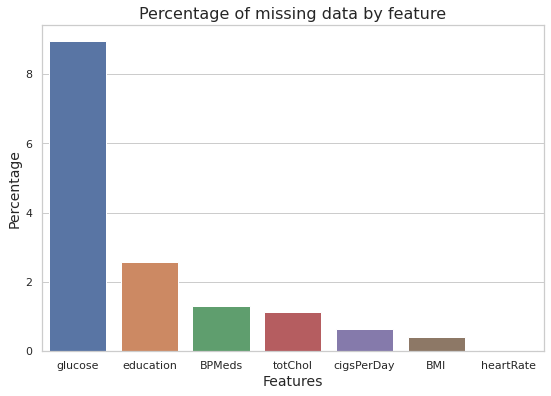

In [ ]:
visualize_missing_percent(dataset)

==>At 8.9%, the glucose column has the highest percentage of missing data. The otherfeatures have very few missing entries.



#####Column Education

Since the educational qualification of the person doesnot have an impact on whether or not they will get a heart disease in future. We are dropping that column

In [ ]:
dataset.drop('education',axis=1,inplace=True)

After dropping of education columns, again checking for null values

Missing values found..Calculating the total...
The total number of missing entries found is 423, that is 12.48%

            Total  Percentage
glucose       304    8.967552
BPMeds         44    1.297935
totChol        38    1.120944
cigsPerDay     22    0.648968
BMI            14    0.412979
heartRate       1    0.029499



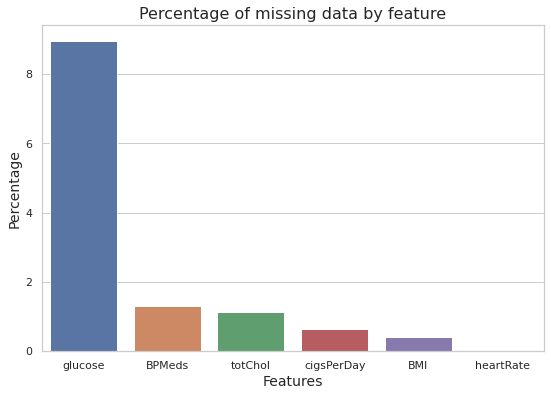

In [ ]:
visualize_missing_percent(dataset)

#####ID

Column ID doesnot contribute to our analysis as this is just a row identifier, we are dropping that.

In [ ]:
dataset.drop('id',axis=1,inplace=True)

####Glucose

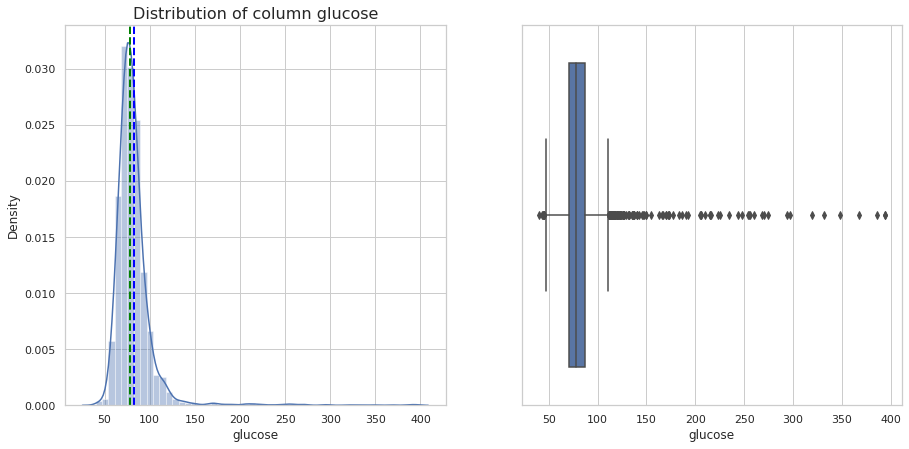

In [ ]:
visualize_num_feature(dataset.glucose)

In [ ]:
#Checking for mean and median on the basis of the presence of diabetes 
print(dataset.groupby('diabetes')['glucose'].mean())
print(dataset.groupby('diabetes')['glucose'].median())

diabetes
0     79.571619
1    171.964286
Name: glucose, dtype: float64
diabetes
0     78.0
1    150.0
Name: glucose, dtype: float64


We are replacing missing value of glucose with median glucose value based on the record that has diabetes or not. 
Blindly replacing the overall median of glucose will not make much sense as glucose levels for persons having diabetes will be higher than persons who do not have diabetes

In [ ]:
dataset.loc[(dataset['diabetes']==1) & (dataset['glucose'].isnull()),'glucose'] = dataset.groupby('diabetes')['glucose'].median()[1]
dataset.loc[(dataset['diabetes']==0) & (dataset['glucose'].isnull()),'glucose'] = dataset.groupby('diabetes')['glucose'].median()[0]

#####Treating outliers

In [ ]:
#getting first and third inter quartile values for the column
first, third = get_iqr(dataset.glucose)

In [ ]:
#Replacing outliers 
dataset.loc[dataset['glucose']>(third + 1.5 * (third-first)),'glucose'] = (third + 1.5 * (third-first))
dataset.loc[dataset['glucose']<(first - 1.5 * (third-first)),'glucose'] = (first - 1.5 * (third-first))

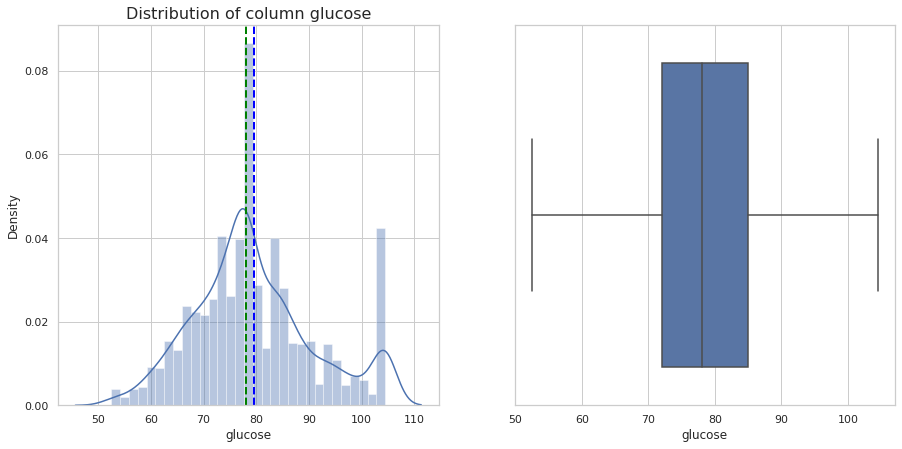

In [ ]:
visualize_num_feature(dataset.glucose)

####BPMeds

In [ ]:
dataset['BPMeds'].value_counts()

0.0    3246
1.0     100
Name: BPMeds, dtype: int64

Replacing BPMeds as 1 if prevalentHyp is 1 and vice versa.
This replacement is done with assumption if the person is suffering from hypertension he/she will be under medication for the same (which is the most common real life scenario). 

In [ ]:
dataset.loc[(dataset['prevalentHyp']==1) & (dataset['BPMeds'].isnull()),'BPMeds'] = 1
dataset.loc[(dataset['prevalentHyp']==0) & (dataset['BPMeds'].isnull()),'BPMeds'] = 0

####Cigaratte per day

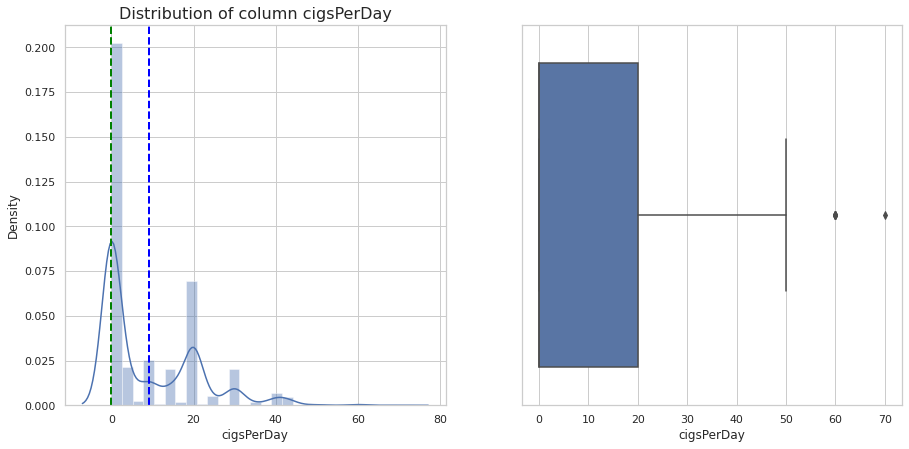

In [ ]:
visualize_num_feature(dataset.cigsPerDay)

In [ ]:
# Replacing null values in cigsPerDay with the mean value of the column
dataset.loc[dataset['cigsPerDay'].isnull(),'cigsPerDay']=np.floor(dataset['cigsPerDay'].mean())

In [ ]:
print(f'The number of outliers present in the column is ',len(dataset[dataset['cigsPerDay']>=50]))

The number of outliers present in the column is  15


#####Treating outliers

In [ ]:
first, third = get_iqr(dataset.cigsPerDay)

In [ ]:
#Replacing the outliers with third quartile range
dataset.loc[dataset['cigsPerDay']>(third + 1.5 * (third-first)),'cigsPerDay'] = (third + 1.5 * (third-first))

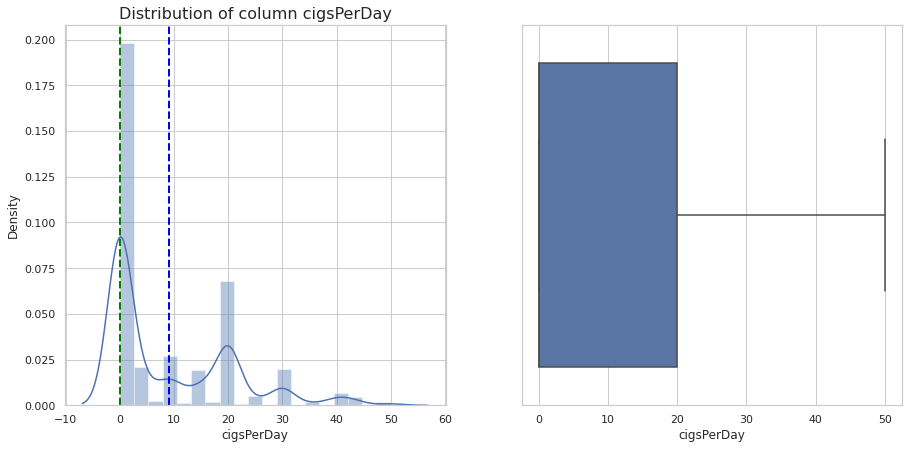

In [ ]:
visualize_num_feature(dataset.cigsPerDay)

####Total cholesterol

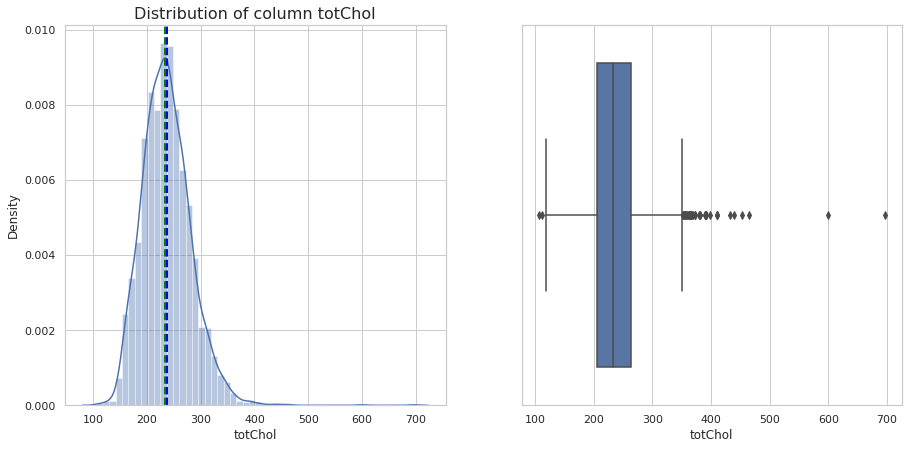

In [ ]:
visualize_num_feature(dataset.totChol)

In [ ]:
#Replacing null values in total cholesterol column with median as the distribution is close to normal
dataset.loc[dataset['totChol'].isnull(),'totChol']=dataset['totChol'].median()

#####Treating outliers

In [ ]:
first, third = get_iqr(dataset.totChol)

In [ ]:
#replacing the outliers with the specified quartile range
dataset.loc[dataset['totChol']>(third + 1.5 * (third-first)),'totChol'] = (third + 1.5 * (third-first))
dataset.loc[dataset['totChol']<(first - 1.5 * (third-first)),'totChol'] = (first - 1.5 * (third-first))

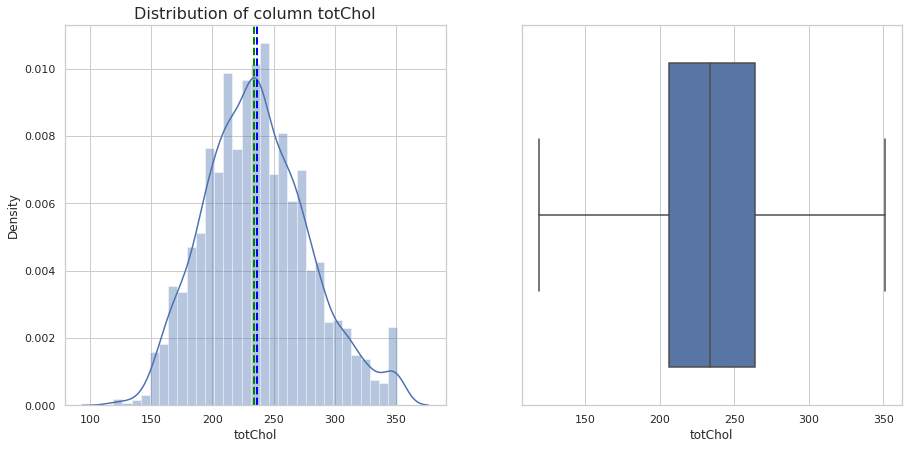

In [ ]:
visualize_num_feature(dataset.totChol)

####BMI

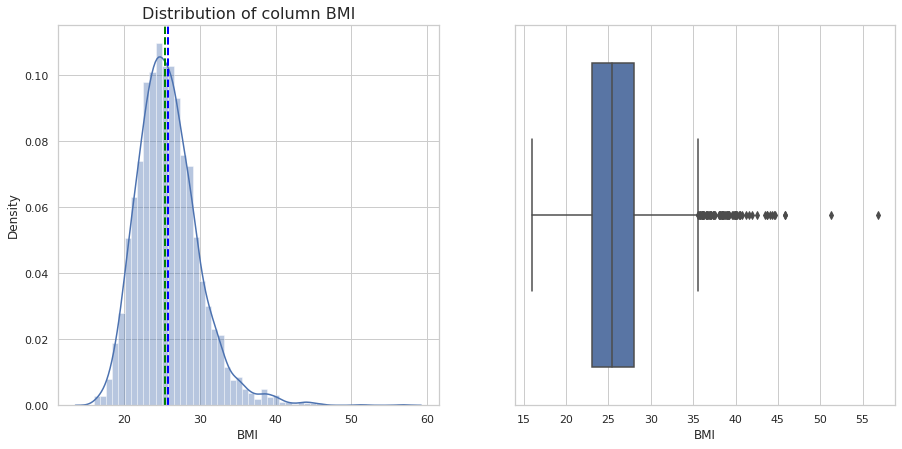

In [ ]:
visualize_num_feature(dataset.BMI)

Since the distribution is close to normal, we are replacing the missing values with median

In [ ]:
#replacing missing values with median value
dataset.loc[dataset['BMI'].isnull(),'BMI']=dataset['BMI'].median()

#####Treating outliers

In [ ]:
first, third = get_iqr(dataset.BMI)

In [ ]:
#replacing the outliers with the specified quartile range
dataset.loc[dataset['BMI']>(third + 1.5 * (third-first)),'BMI'] = (third + 1.5 * (third-first))
dataset.loc[dataset['BMI']<(first - 1.5 * (third-first)),'BMI'] = (first - 1.5 * (third-first))

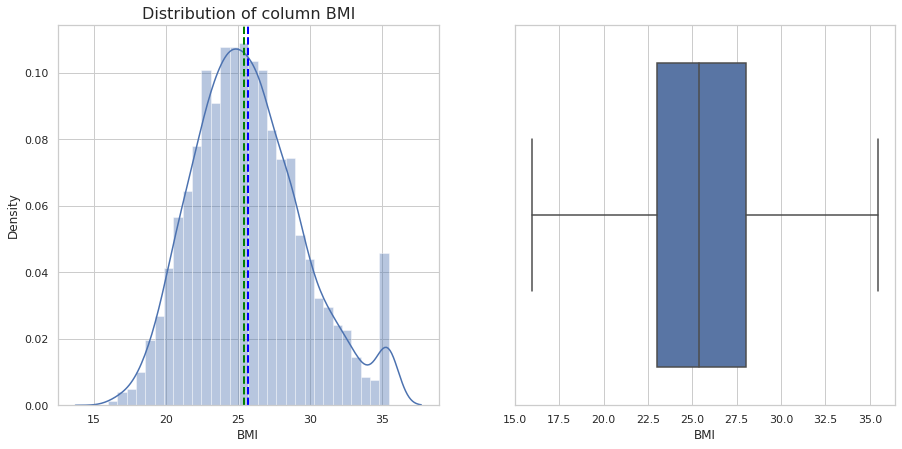

In [ ]:
visualize_num_feature(dataset.BMI)

####Heart rate

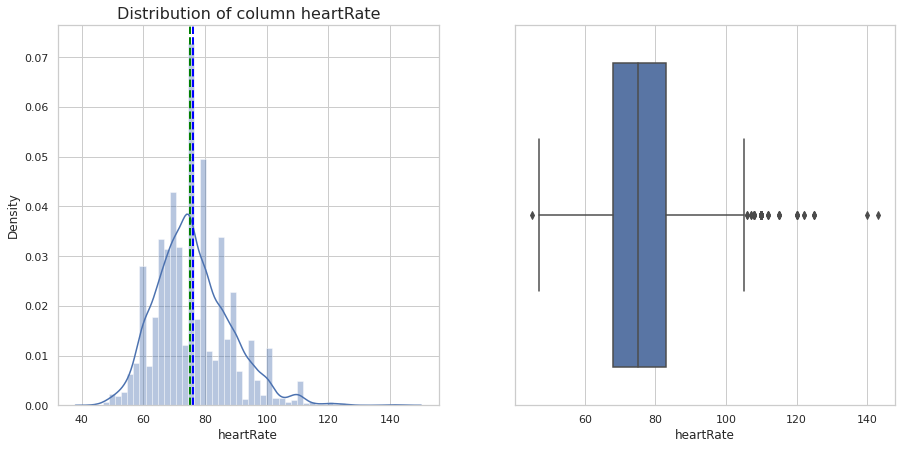

In [ ]:
visualize_num_feature(dataset.heartRate)

In [ ]:
#Replacing null values in total cholesterol column with median as the distribution is close to normal
dataset.loc[dataset['heartRate'].isnull(),'heartRate']=dataset['heartRate'].median()

#####Treating outliers

In [ ]:
first, third = get_iqr(dataset.heartRate)

In [ ]:
#replacing the outliers with the specified quartile range
dataset.loc[dataset['heartRate']>(third + 1.5 * (third-first)),'heartRate'] = (third + 1.5 * (third-first))
dataset.loc[dataset['heartRate']<(first - 1.5 * (third-first)),'heartRate'] = (first - 1.5 * (third-first))

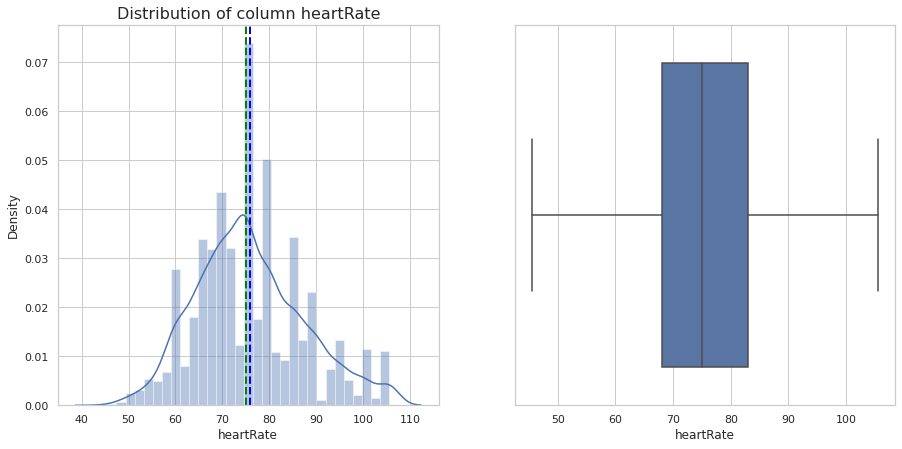

In [ ]:
visualize_num_feature(dataset.heartRate)

####Dia BP

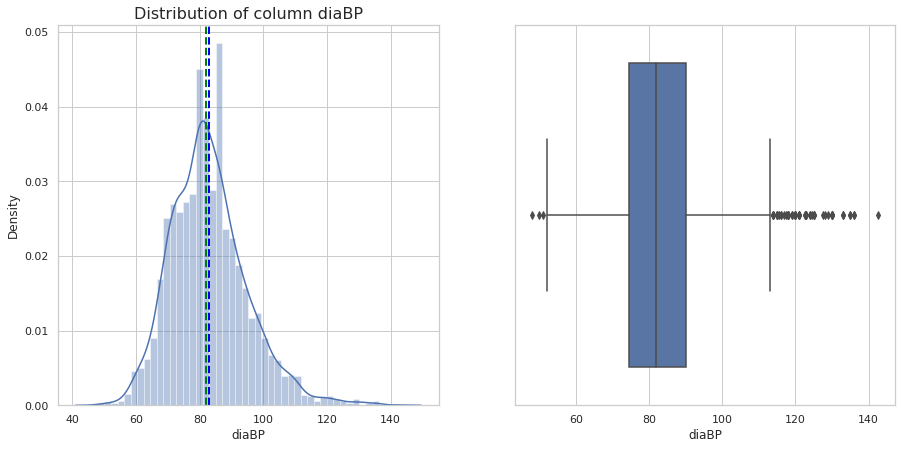

In [ ]:
visualize_num_feature(dataset.diaBP)

In [ ]:
first, third = get_iqr(dataset.diaBP)

In [ ]:
#replacing the outliers with the specified quartile range
dataset.loc[dataset['diaBP']>(third + 1.5 * (third-first)),'diaBP'] = (third + 1.5 * (third-first))
dataset.loc[dataset['diaBP']<(first - 1.5 * (third-first)),'diaBP'] = (third + 1.5 * (third-first))

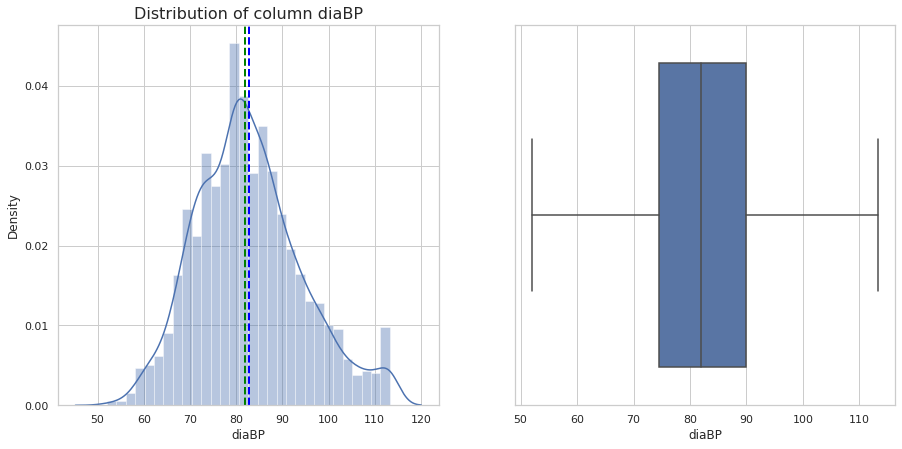

In [ ]:
visualize_num_feature(dataset.diaBP)

####Column Age

In [ ]:
print("The minimun age present in the dataset is "+str(dataset['age'].min()))
print("The minimun age present in the dataset is "+str(dataset['age'].max()))

The minimun age present in the dataset is 32
The minimun age present in the dataset is 70


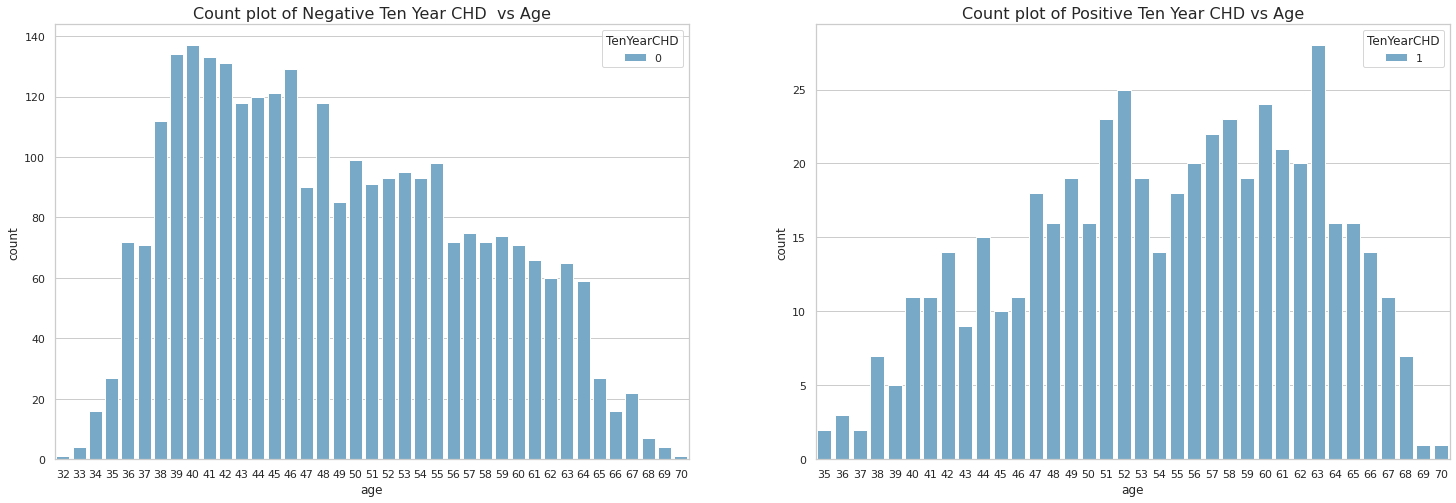

In [ ]:
#plotting count plot for both negative ten year CD and positive ten year CHD with age to analyze the effect from age
positive_cases = dataset[dataset['TenYearCHD'] == 0]
plt.figure(figsize=(25,8))
plt.subplot(1,2,1)
sns.countplot(x='age',data = positive_cases, hue = 'TenYearCHD', palette='Blues')
plt.title("Count plot of Negative Ten Year CHD  vs Age", fontsize=16)

negative_cases = dataset[dataset['TenYearCHD'] == 1]
plt.subplot(1,2,2)
sns.countplot(x='age',data = negative_cases, hue = 'TenYearCHD', palette='Blues')
plt.title("Count plot of Positive Ten Year CHD vs Age", fontsize=16)

plt.show()


==> The chances of Getting Coronary Heart Disease is less for the lower age groups

#####Sex

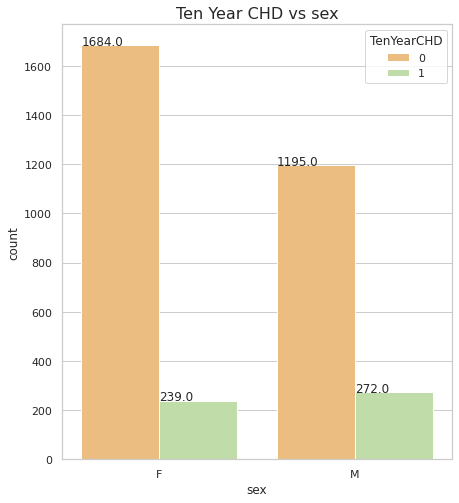

In [ ]:
visualize_cat_feature(dataset.sex)

==> 12.4% of females have the chances of getting CHD.
18.5% of males have the chances of getting CHD

Chance of getting CHD in ten years is more among Males

####is smoking

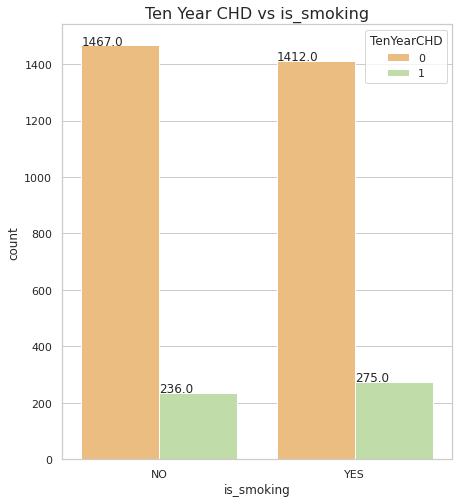

In [ ]:
visualize_cat_feature(dataset.is_smoking)

==>13.8% of non smokers get CHD.
==>16.3% of smokers get CHD.
<br>

So, risk of 10 year CHD is more in Smokers.

In [ ]:
new_rows = dataset.shape[0]

In [ ]:
print(round((new_rows/original_rows)*100,2),"% of data is retained after cleaning and analysis")

100.0 % of data is retained after cleaning and analysis


Since the dataset is small, we will be utilizing 100% of data without loosing any.

###**Dependent Variable (TenYearCHD) analysis**





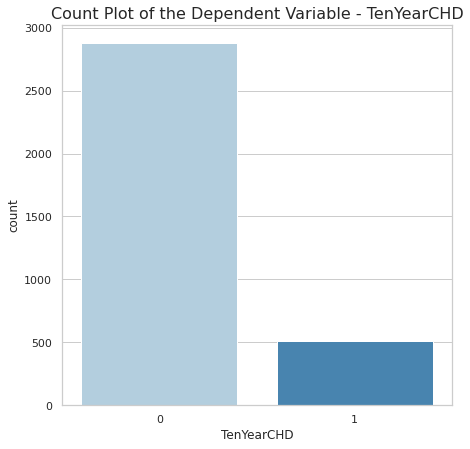

In [ ]:
#plotting count plot of target variable 
plt.figure(figsize=(7,7))
sns.countplot(x=dataset['TenYearCHD'],palette='Blues')
plt.title("Count Plot of the Dependent Variable - TenYearCHD",fontsize=16)
plt.show()

==>We can observe a huge difference in the count of zeros and ones in the dependent variable.Dependent variable is highly imbalanced.


###**Univariate analysis**

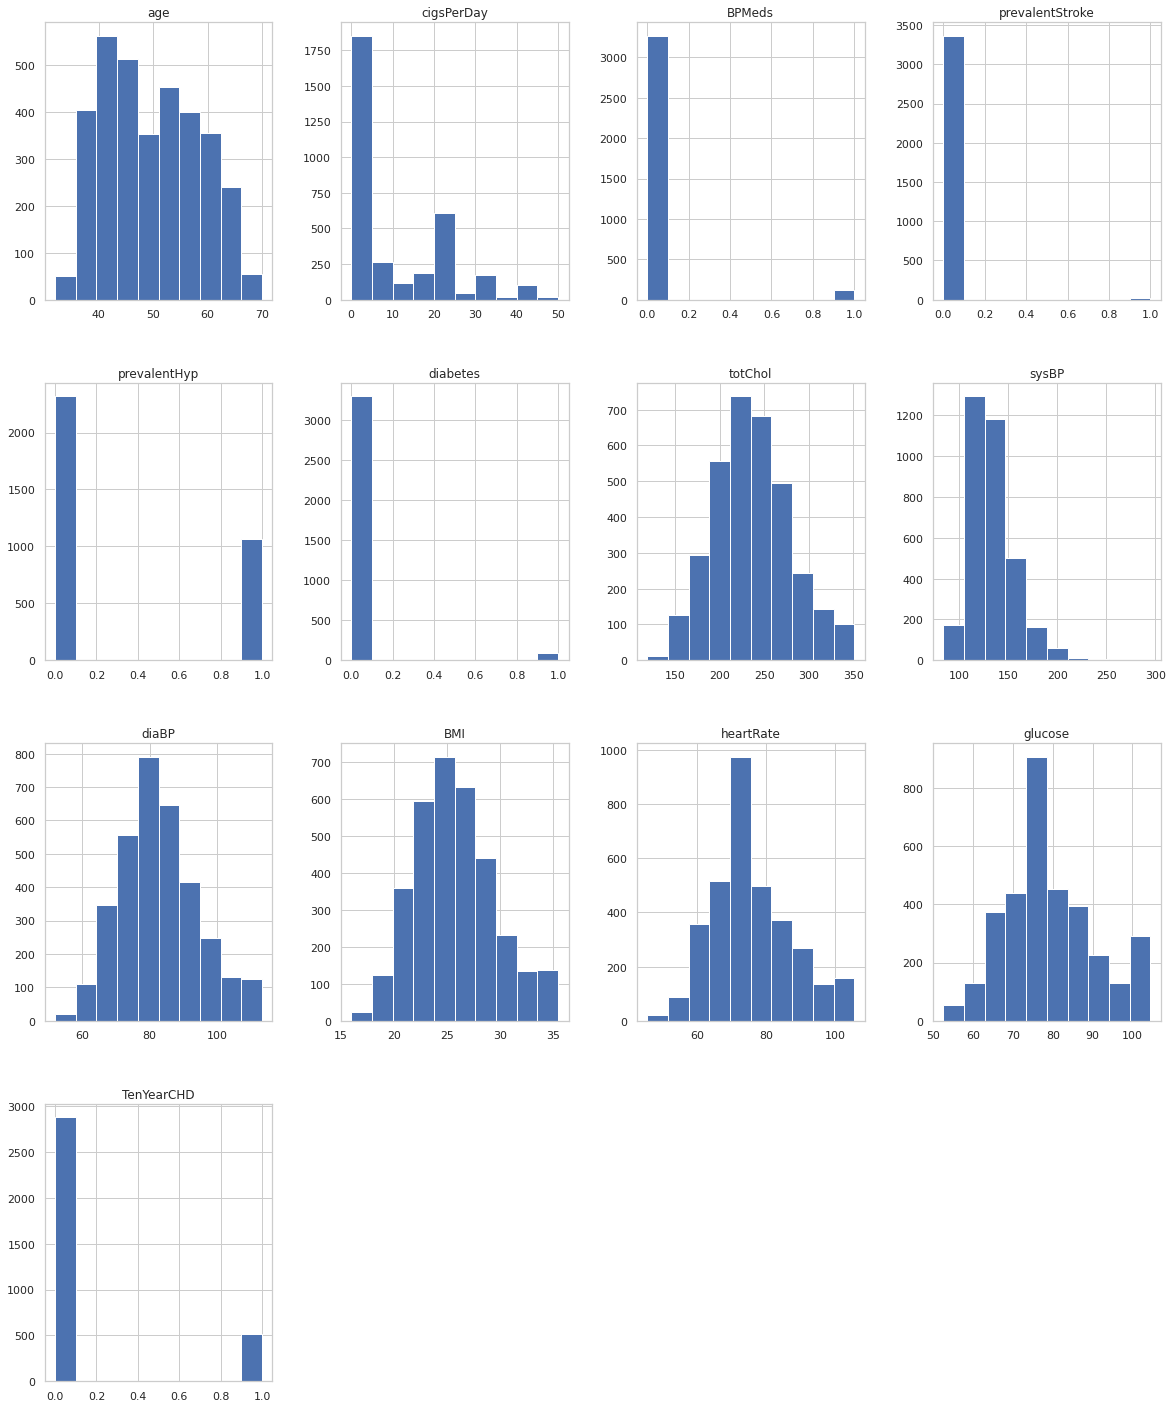

In [ ]:
# plot histogram to see the distribution of the data
fig = plt.figure(figsize = (20,25))
ax = fig.gca()
dataset.hist(ax = ax) #color='light blue')
plt.show()

###**Bi-Variate Analysis**

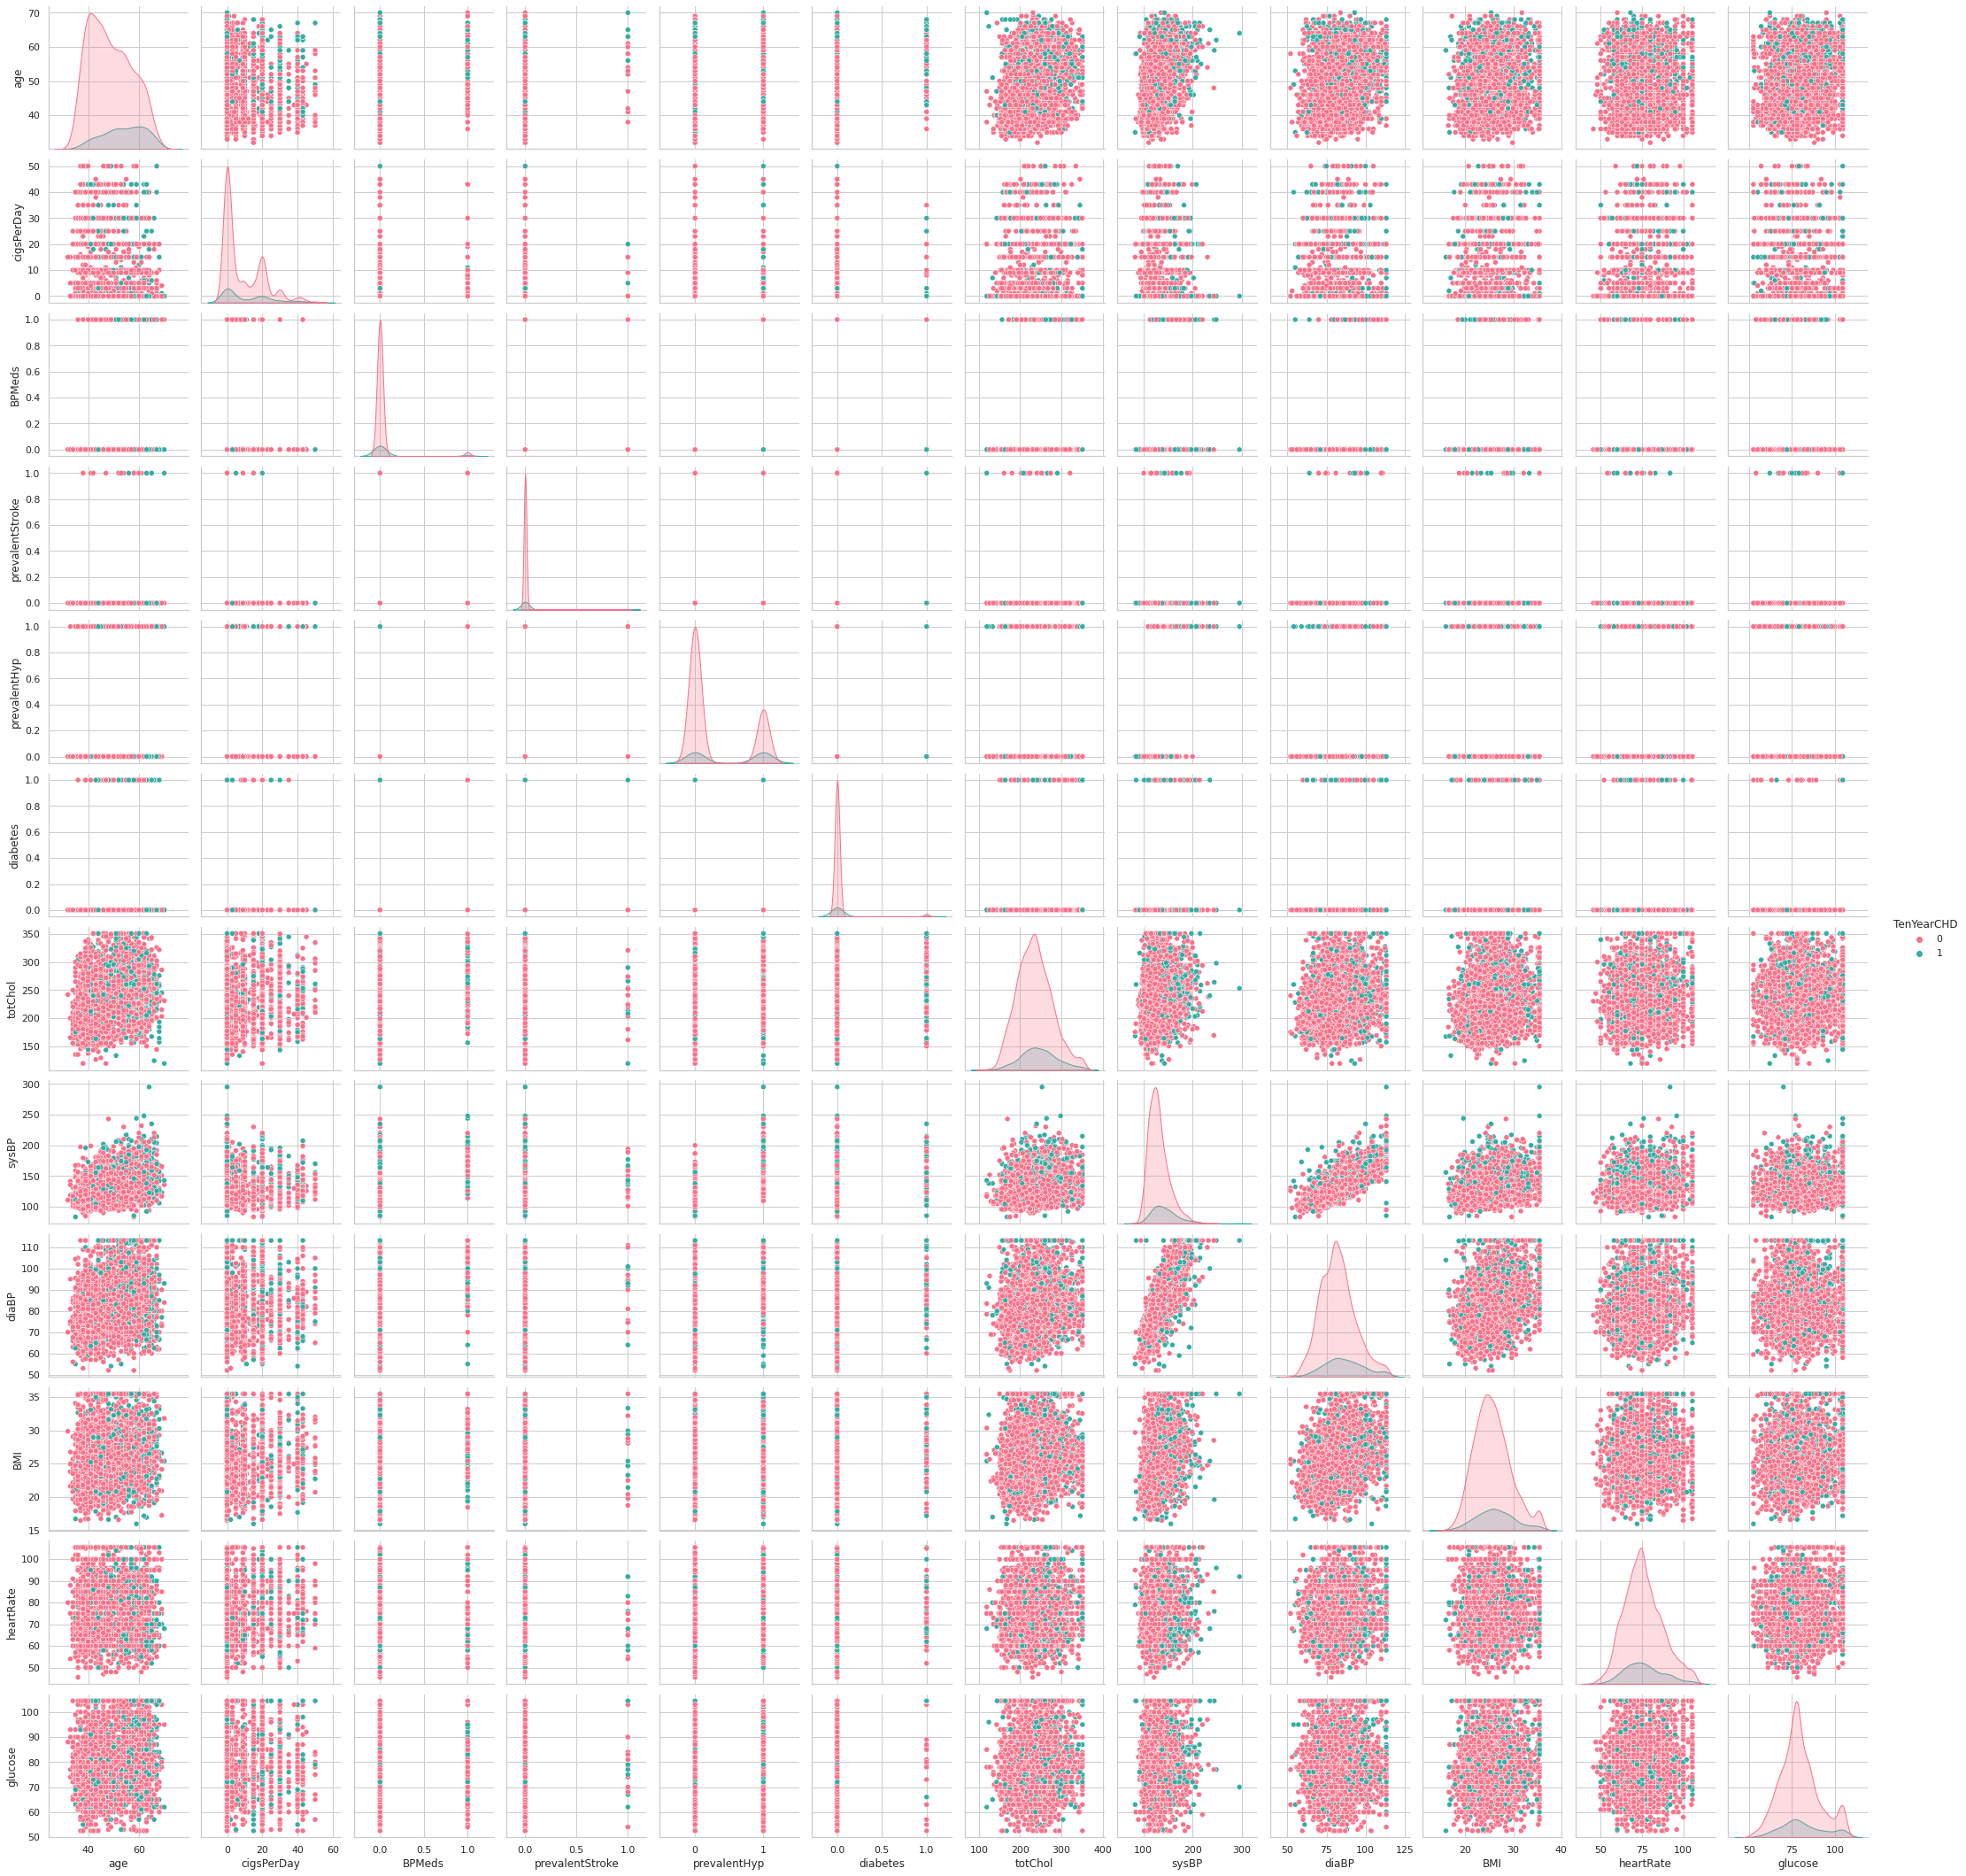

In [ ]:
sns.pairplot(dataset, hue ='TenYearCHD', palette='husl')
plt.show()

In [ ]:
#From the above, we can segredate continuous and categorical variable  
continuous_features = ['age','cigsPerDay','totChol','sysBP','diaBP','BMI','heartRate','glucose']
categorical_features = ['BPMeds','prevalentStroke','prevalentHyp','diabetes']

###**Multivariate Analysis**

Plotting heatmap to see the correlation among the variables.

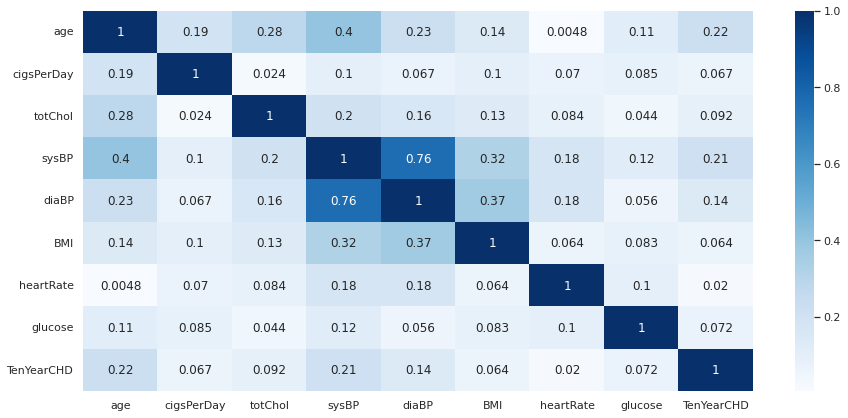

In [ ]:
# Plotting heatmap for numerical variables
plt.figure(figsize=(15,7))
sns.heatmap (abs(dataset.drop(categorical_features, axis=1).corr()),annot = True, cmap='Blues')
plt.show()

In [ ]:
# Getting the variance inflaction factor dataframe
vif_df = calc_vif(dataset[[i for i in dataset.describe().columns if i not in ['TenYearCHD','prevalentHyp','diabetes','prevalentStroke',
                                                                             'diaBP','BMI','heartRate','totChol','BPMeds' ]]])
vif_df

variables        VIF
0         age  36.360854
1  cigsPerDay   1.559020
2       sysBP  37.944527
3     glucose  29.343620

After removing the highly correlated variable we are left with the variables mentioned below.

In [ ]:
numerical_features=list(vif_df['variables'])
numerical_features

['age', 'cigsPerDay', 'sysBP', 'glucose']

####Changing the datatype of categorical features

In [ ]:
categorical_features.extend(['sex','is_smoking'])
categorical_features

['BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'sex', 'is_smoking']

In [ ]:
#Changing datatype
#Change the int64 column into category column
for col in categorical_features:
  dataset[col]=dataset[col].astype('category')

#####Visualizing categorical features

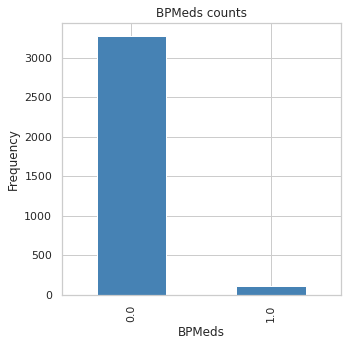

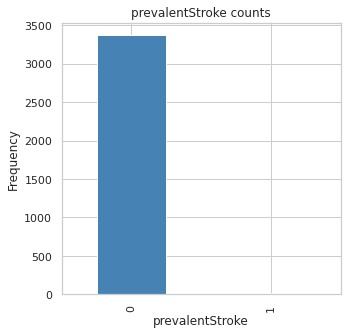

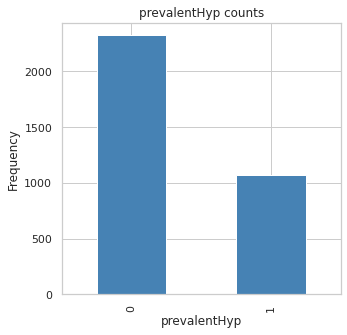

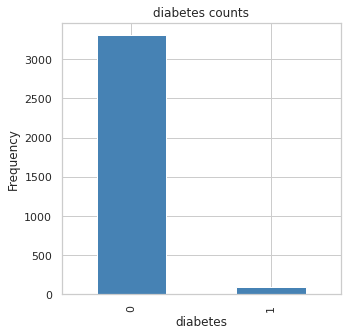

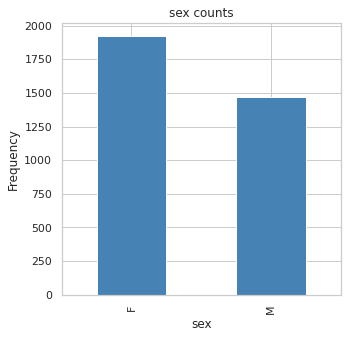

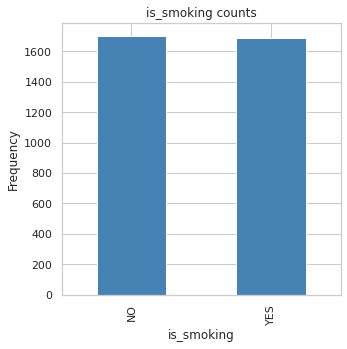

In [ ]:
for col in categorical_features:
    counts = dataset[col].value_counts().sort_index()
    fig = plt.figure(figsize=(5, 5))
    ax = fig.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col) 
    ax.set_ylabel("Frequency")
plt.show()

####One hot encoding

In [ ]:
#Encoding the binary categorical columns
encoders_nums = {"sex":{"M":1,"F":0},"is_smoking":{"YES":1,"NO":0}}

In [ ]:
#As we are taking continuous column cigsPerDay, we are dropping is_smoking column
dataset.drop('is_smoking',axis=1,inplace=True)
categorical_features.remove('is_smoking')

In [ ]:
dataset = dataset.replace(encoders_nums)
dataset.head()

age  sex  cigsPerDay BPMeds prevalentStroke prevalentHyp diabetes  totChol  \
0   64    0         3.0    0.0               0            0        0    221.0   
1   36    1         0.0    0.0               0            1        0    212.0   
2   46    0        10.0    0.0               0            0        0    250.0   
3   50    1        20.0    0.0               0            1        0    233.0   
4   64    0        30.0    0.0               0            0        0    241.0   

   sysBP  diaBP    BMI  heartRate  glucose  TenYearCHD  
0  148.0   85.0  25.38       90.0     80.0           1  
1  168.0   98.0  29.77       72.0     75.0           0  
2  116.0   71.0  20.35       88.0     94.0           0  
3  158.0   88.0  28.26       68.0     94.0           1  
4  136.5   85.0  26.42       70.0     77.0           0

###**Feature Selection**

We are retaining sysBP which is related to the blood pressure of a person,so we are dropping the column prevalentHyp from the feature.
<br>
<br>
As there are very less count of ones in prevalentStroke column, it will not add much to our model building. Hence we are removing prevalentStroke from our analysis.
<br>
<br>
As we are going forward with the glucose column which is also an indicator of diabetes, we can drop the column diabetes.
<br>
<br>
We are dropping BPMeds column as there is a huge imbalance in the classes and we already have one column related to Blood Presssure.



In [ ]:
features = numerical_features + categorical_features
features.remove('prevalentHyp')
features.remove('prevalentStroke')
features.remove('diabetes')
features.remove('BPMeds')

In [ ]:
#These are the features that we are using to train our model
features

['age', 'cigsPerDay', 'sysBP', 'glucose', 'sex']

In [ ]:
dataset[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         3390 non-null   int64  
 1   cigsPerDay  3390 non-null   float64
 2   sysBP       3390 non-null   float64
 3   glucose     3390 non-null   float64
 4   sex         3390 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 132.5 KB


##**Model Prerequisites**

Applying zscore to standardize the input variables.

In [ ]:
#Scaling the input columns
X = dataset[features].apply(zscore)

In [ ]:
Y = dataset['TenYearCHD']

In [ ]:
#Scoring is used to define the parameter we are concentrating on to maximize
scoring = make_scorer(f1_score , pos_label = 1)

###**Smote Tomek**

As we observed a huge imbalance in the dependent variable, we are applying SMOTE to synthesize data point for the minority class.

SMOTE stands for **Synthetic Minority Oversampling TEchnique**.

Smote tomek is an improved hyprodization technique of SMOTE. Hybridization techniques involve combining both undersampling and oversampling techniques. This is done to optimize the performance of classifier models for the samples created as part of these techniques.

SMOTE+TOMEK is a hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space. After the oversampling is done by SMOTE, the class clusters may be invading each other’s space. As a result, the classifier model will be overfitting. Tomek links are the opposite class paired samples that are the closest neighbors to each other. Therefore the majority of class observations from these links are removed as it is believed to increase the class separation near the decision boundaries. Now, to get better class clusters, Tomek links are applied to oversampled minority class samples done by SMOTE. 

In [ ]:
#Splitting our dataset into train and test data
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.20, random_state=0, stratify= Y)

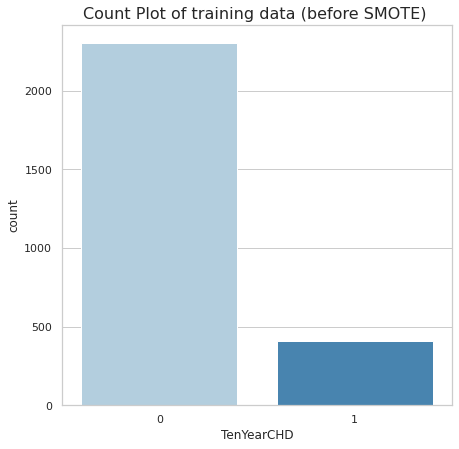

In [ ]:
plt.figure(figsize=(7,7))
sns.countplot(x=Y_train,palette='Blues')
plt.title("Count Plot of training data (before SMOTE) ",fontsize=16)
plt.show()

In [ ]:
#Applying smote for train data
X_smotetomek, y_smotetomek = SMOTETomek(random_state=0, sampling_strategy='minority').fit_resample(X_train, Y_train)

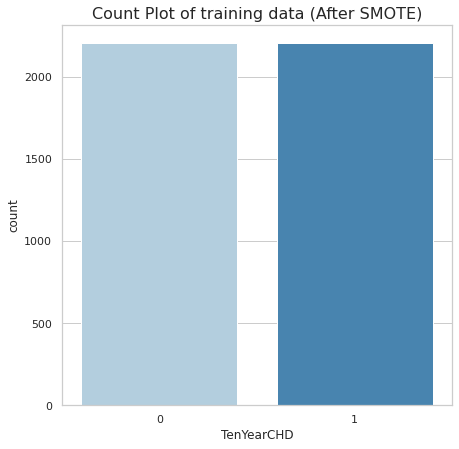

In [ ]:
plt.figure(figsize=(7,7))
sns.countplot(x=y_smotetomek,palette='Blues')
plt.title("Count Plot of training data (After SMOTE)",fontsize=16)
plt.show()

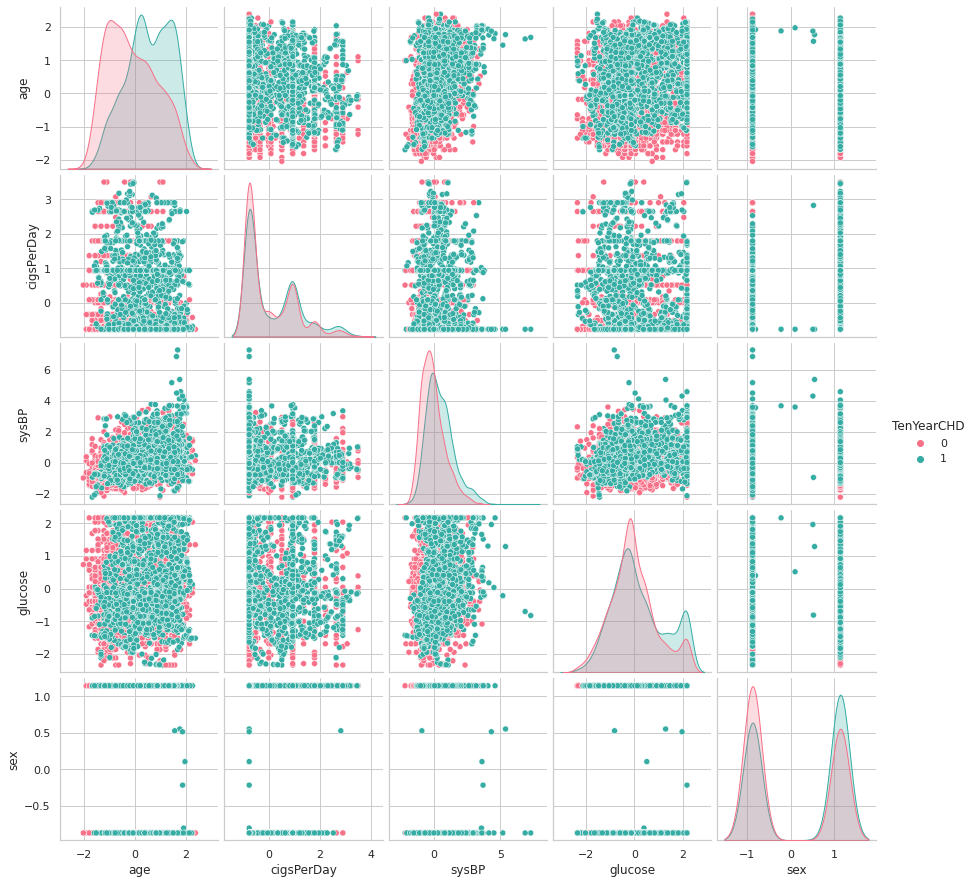

In [ ]:
#Printing pairplot for the features after smote
smotetoemk_df = pd.concat([X_smotetomek,y_smotetomek], axis = 1)
sns.pairplot(smotetoemk_df, hue='TenYearCHD',palette='husl')
plt.show()

##**Models**

####**Evaluation Metrics**

**True Positive(TP):** A positive sample was retrieved, which is actually a positive sample (correctly identified)


**False Positive(FP):** A positive sample was retrieved, but it was actually a negative sample (a type of misidentification)


**False Negative(FN):** No positive sample has been retrieved, but it is actually a positive sample. (Another type of misidentification)


**True Negative(TN):** No positive sample has been retrieved, but it is actually a negative sample. (Correct identification)





**Precision:** The precision is the ratio of tp/(tp + fp), where tp is the correct number of positive samples and fp is the number of false positives.

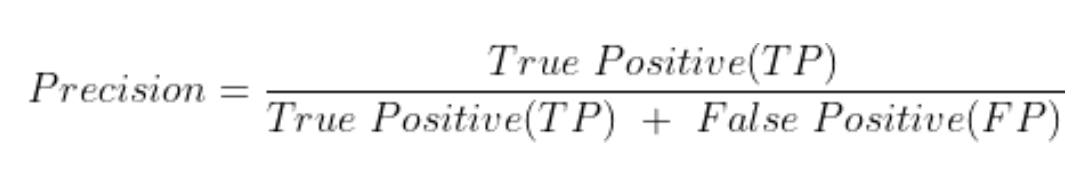

**Recall:**  Recall tell us how sensitive our model is to the positive class, and we see it is also referred to as Sensitivity. Recall measures the proportion of actual positive labels correctly identified by the model.

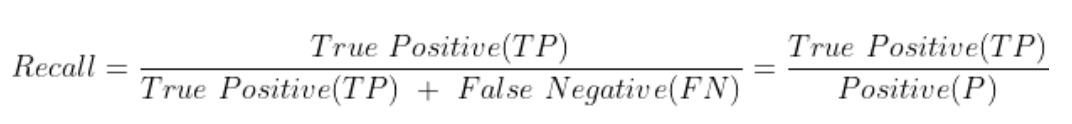

**Accuracy:** In machine learning, accuracy is defined as the proportion of correct predictions in all predictions made. 

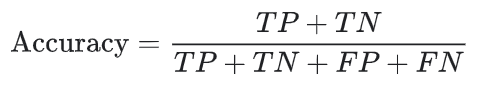



**F1 Score:** F1 score is a metric that combines both Precision and Recall. Also f1-score lies between 0 to 1 and the higher, the better.

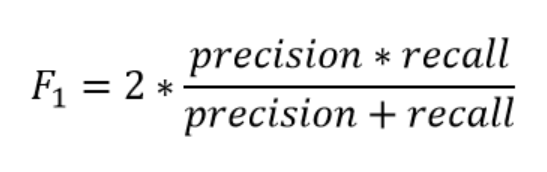

**ROC-AUC:** ROC stands for Receiver Operating Characteristic. The ROC curve is a graphical plot. Its purpose is to illustrate our classification model’s ability to distinguish between classes at various thresholds.

AUC is the acronym for the Area Under Curve. It is the summary of the ROC curve that tells about how good a model is when we talk about its ability to generalize.

Greater the area under this curve (AUC), the greater the model’s ability to separate the responses.



####**Logistic Regression**

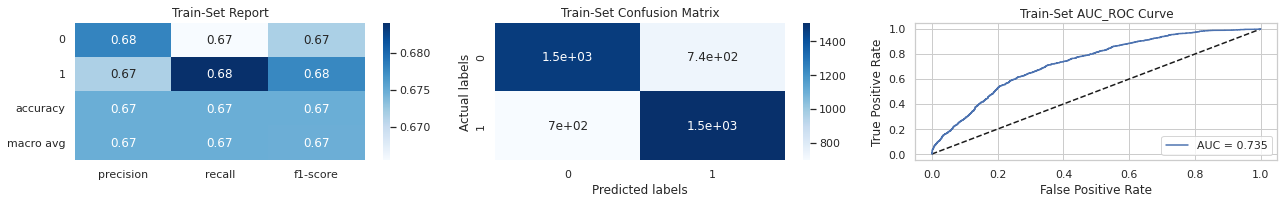

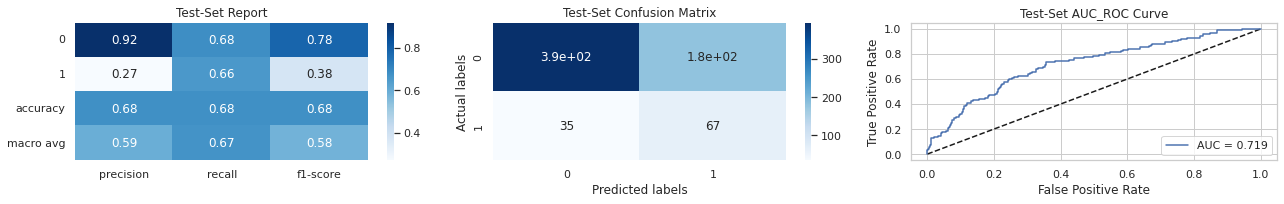

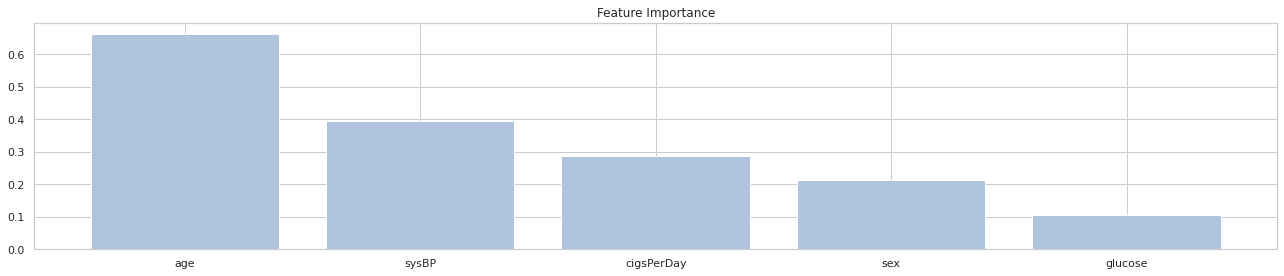

LogisticRegression(max_iter=1000)

In [ ]:
reg = LogisticRegression(max_iter=1000)
analyse_model(reg,X_smotetomek,X_test,y_smotetomek,Y_test)

####**Random Forest Classifier**

In [ ]:
# Number of trees
n_estimators = [50,80,100]

# Maximum depth of trees
max_depth = [4,6,8]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Grid
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [ ]:
# Create an instance of the RandomForestClassifier
rf_model = RandomForestClassifier()

# Grid search to fit the model for 5 fold cross validation
rf_grid = GridSearchCV(estimator=rf_model,
                       param_grid = param_dict,
                       scoring = scoring,
                       cv = 5, 
                       )

print("Fitting the model for 5 fold Cross Validations...")
rf_grid.fit(X_smotetomek,y_smotetomek)



Fitting the model for 5 fold Cross Validations...


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 6, 8], 'min_samples_leaf': [40, 50],
                         'min_samples_split': [50, 100, 150],
                         'n_estimators': [50, 80, 100]},
             scoring=make_scorer(f1_score, pos_label=1))

In [ ]:
print(f'The best estimator model is {rf_grid.best_estimator_}')
print(f'The best fit parameters are {rf_grid.best_params_}')

The best estimator model is RandomForestClassifier(max_depth=8, min_samples_leaf=40, min_samples_split=100,
                       n_estimators=50)
The best fit parameters are {'max_depth': 8, 'min_samples_leaf': 40, 'min_samples_split': 100, 'n_estimators': 50}


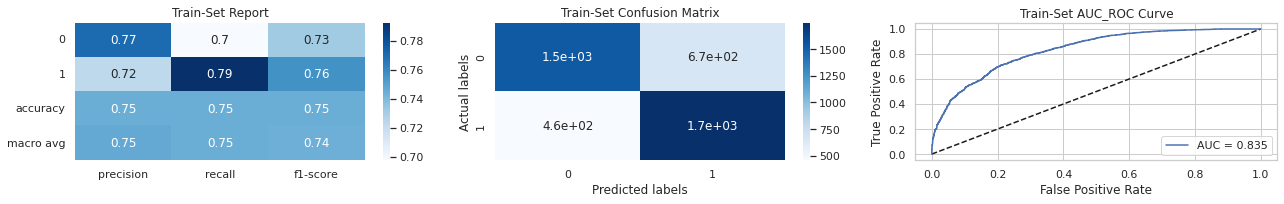

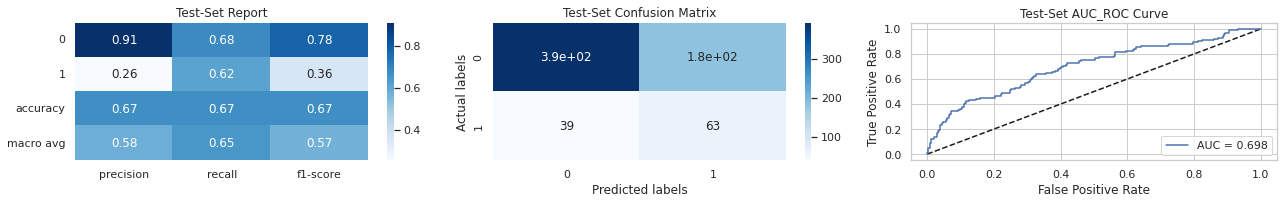

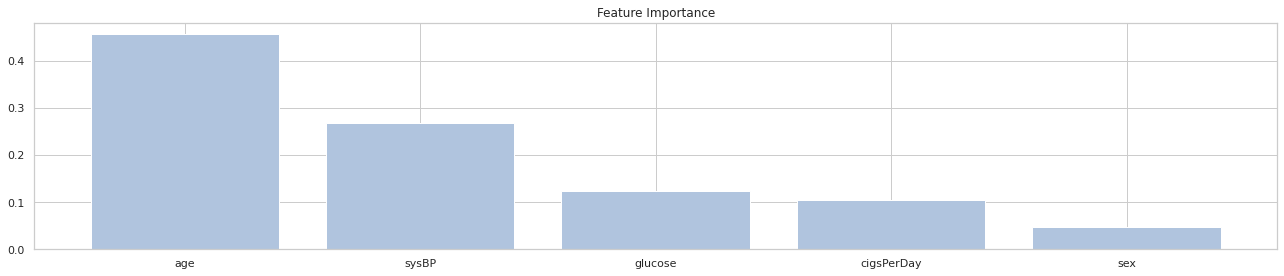

RandomForestClassifier(max_depth=8, min_samples_leaf=40, min_samples_split=100,
                       n_estimators=50)

In [ ]:
analyse_model(rf_grid.best_estimator_, X_smotetomek, X_test, y_smotetomek, Y_test)

From feature importance we can observe that 'age' is playing an vital role in predicting the CHD risk.

####**Extreme Gradient Boost Classifier(XGB)**

In [ ]:
# Number of trees
n_estimators = [140,160]

# # # Maximum depth of trees
# max_depth = [4,6]

# learning rate for the model
learning_rate=[0.1,0.01,0.001]

# # Minimum number of sub samples required 
# subsample=[0.6,0.7,0.8]

#minimum sample split
min_sample_split = [20,30,40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [30,50,70]


# Hyperparameter Grid
param_dict = {'n_estimators' : n_estimators,
              # 'max_depth' : max_depth,
              'learning_rate' : learning_rate,
              # 'subsample' : subsample
              'min_sample_split':min_sample_split,
              'min_samples_leaf':min_samples_leaf}

# Create an instance of the RandomForestClassifier
xgb_model = xgb.XGBClassifier()

# Grid search
xgb_grid = GridSearchCV(estimator=xgb_model,
                       param_grid = param_dict,
                        scoring = scoring,
                       cv = 5, #verbose=2,
                        )

print("Fitting the model for 5 fold Cross Validations...")
xgb_grid.fit(X_smotetomek,y_smotetomek)


Fitting the model for 5 fold Cross Validations...


GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'min_sample_split': [20, 30, 40],
                         'min_samples_leaf': [30, 50, 70],
                         'n_estimators': [140, 160]},
             scoring=make_scorer(f1_score, pos_label=1))

In [ ]:
print(f'The best estimator model is {xgb_grid.best_estimator_}')
print(f'The best fit parameters are {xgb_grid.best_params_}')

The best estimator model is XGBClassifier(min_sample_split=20, min_samples_leaf=30, n_estimators=140)
The best fit parameters are {'learning_rate': 0.1, 'min_sample_split': 20, 'min_samples_leaf': 30, 'n_estimators': 140}


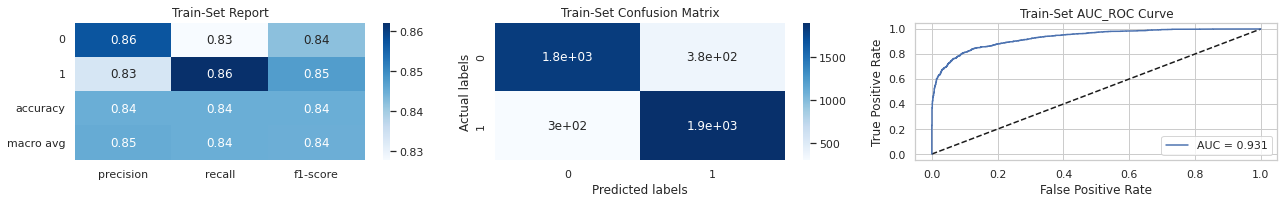

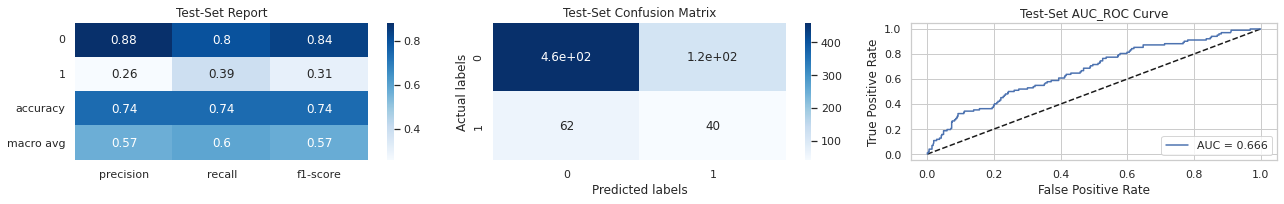

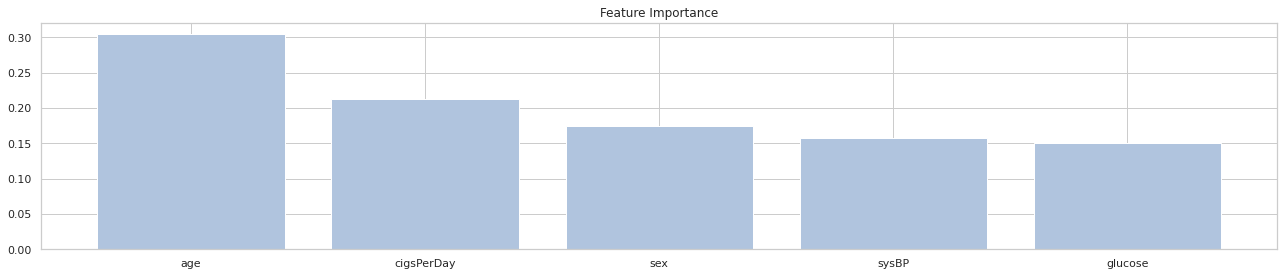

XGBClassifier(min_sample_split=20, min_samples_leaf=30, n_estimators=140)

In [ ]:
analyse_model(xgb_grid.best_estimator_, X_smotetomek, X_test, y_smotetomek, Y_test)

Here again we can observe that 'age' is playing an vital role in predicting the 10 year CHD risk.

####**Suppot Vector Classifier(SVM)**


In [ ]:
# SVM algorithm
clf = SVC(random_state= 0,probability=True)
# scoring_1 = make_scorer(f1_score, pos_label = 1)
# HYperparameter Grid
grid = {'kernel': ["linear","rbf","poly","sigmoid"],
        'C': [0.01,0.1, 1, 10, 100],
        'max_iter' : [1000]}

# GridSearch to find the best parameters
svc = GridSearchCV(clf, param_grid = grid, scoring = scoring, cv=5)
print('Fitting the model for 5 fold Cross Validation')
svc.fit(X_smotetomek, y_smotetomek)



Fitting the model for 5 fold Cross Validation


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=0),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                         'max_iter': [1000]},
             scoring=make_scorer(f1_score, pos_label=1))

In [ ]:
print(f'The best estimator model is {svc.best_estimator_}')
print(f'The best fit parameters are {svc.best_params_}')

The best estimator model is SVC(C=0.1, max_iter=1000, probability=True, random_state=0)
The best fit parameters are {'C': 0.1, 'kernel': 'rbf', 'max_iter': 1000}


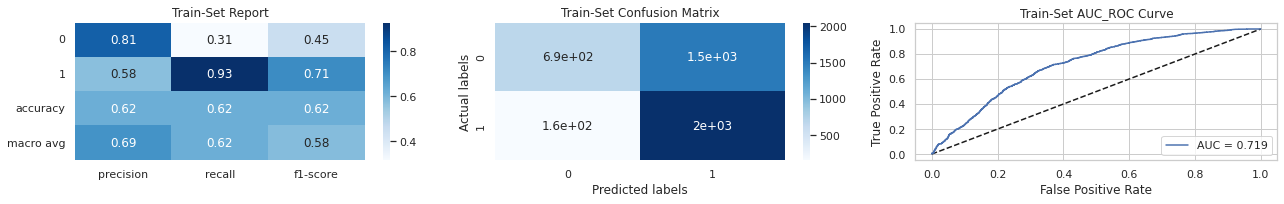

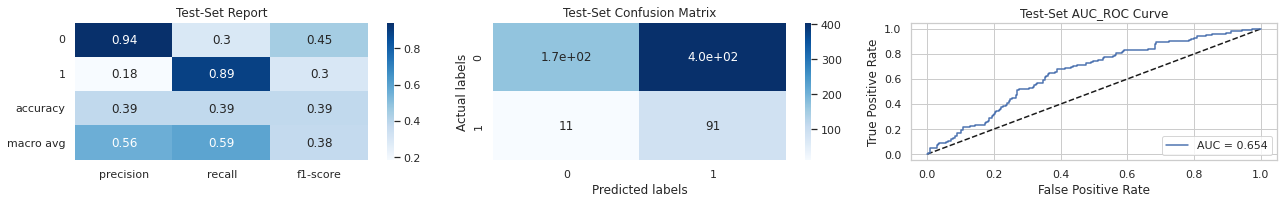

<Figure size 1296x288 with 0 Axes>

SVC(C=0.1, max_iter=1000, probability=True, random_state=0)

In [ ]:
# Analysing the model with best set of parametes
analyse_model(svc.best_estimator_, X_smotetomek, X_test, y_smotetomek , Y_test)

##**Conclusion**

We initially started exploring the dataset and got familiarized ourselves with the features present in it. We performed Exploratory Data Analysis on every feature of the dataset and can conclude the following:

*   In total out of 3390 records, only 500 people are at risk i.e., there is a
huge imbalance in the data.
* Age is the feature that is most important in determining if the person will be prone to coronary heart disease  (CHD) in ten years.
* Systolic Blood Pressure is the second most important feature in determining the CHD.
*	Male population is slightly more likely to get CHD when compared to females.
*	Smokers and Non-Smokers are almost equally likely to get CHD when the number of cigarettes smoked per day is less. As the number of cigarettes smoked increases the risk increases.







We have cleaned the dataset by replacing the missing values and capping the outliers. Then through the help of variance inflation factor and correlation maps, we selected the features to train the models.
<br>
<br>
We then split the data into train and test sets with train set having 80% of the data and 20% in the test set.
<br>
<br>
Since the dataset had huge imbalance in it, we have added synthetic data points using SMOTE (Synthetic Minority Oversampling TEchinque). We applied SMOTE only to the train split, as applying to the whole set would lead the model to overfit. Also, we have removed the TOMEK links so that the data can be classified efficiently.
<br>


Since this classification is related to predicting the health of a person, we need to be cautious that any misclassification in predicting Ten-year CHD as **NO** when the actual result was **YES** could cost us a lot. Hence, we desire to have high recall score for class 1 in the model.

After SMOTE we started with Logistic Regression and understood that it is not able to classify the data with desired accuracy.
<br>
Then we tried with Random Forest Classifier, Gradient Boost Classifier and Support Vector Machines (SVM). Among the three classifiers, we observed that SVM can classify the data with desired scores.
<br>
Support Vector Classifier is giving us the recall score of 93% in training and 89% in test data.
<br>
<br>
Hence we can conclude that Support Vector Classifier is the best classification algorithm with **89%** recall score for class 1.